## Portfolio optimization using Markowitz efficient frontier and Bootstrap forecast cones

In [428]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-muted')
import pandas_datareader.data as web
from datetime import datetime as dt
import statsmodels.api as sm

In [2]:
today = dt.today().strftime('%Y-%m-%d')
start = dt(2017,1,1).strftime('%Y-%m-%d')
stocks = web.DataReader(['AMZN','MSFT','TSLA','GOOG','AAPL','FB',],
               data_source='yahoo',
               start=start,
               end=today)

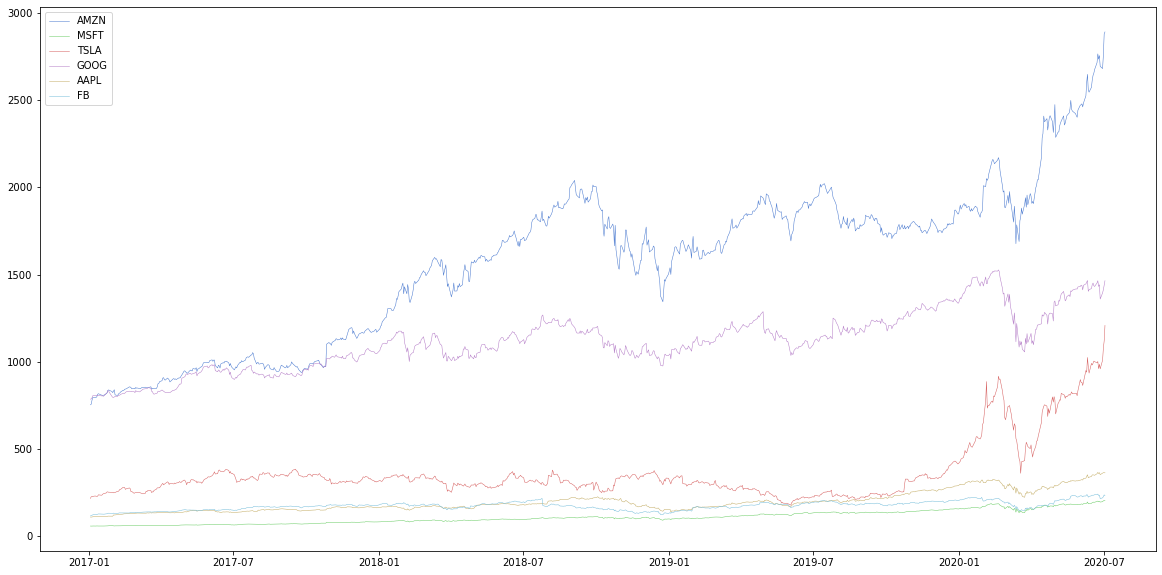

In [3]:
def plotStocks(stocks):
    """Stock plotting function. The portfolio is drawn thicker"""
    lw = 0.5
    names = stocks.columns.values
    plt.figure(figsize=(20,10))
    for name in names:
        price = stocks[name]
        if name == 'portfolio':
            lw = 4
        else:
            lw = 0.5
        plt.plot(stocks[name],label = name,linewidth = lw)
        
    plt.legend()

closing = stocks['Adj Close']
plotStocks(closing)


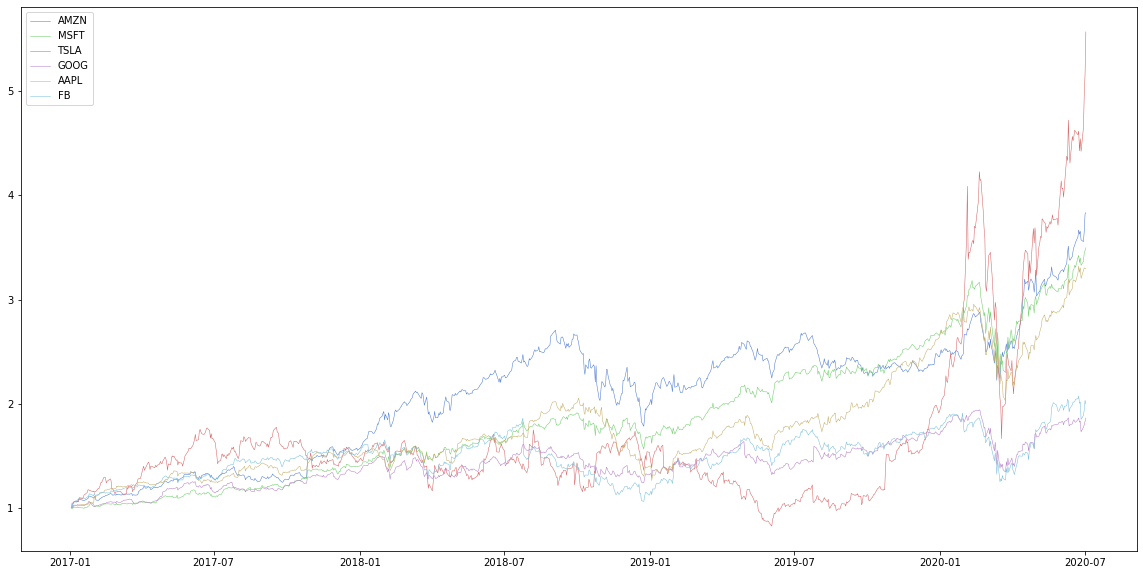

In [4]:
#Instead lets look at the relative change between prices. That is, lets have them all start at 1.
returns = closing/closing.iloc[0,:]
plotStocks(returns)

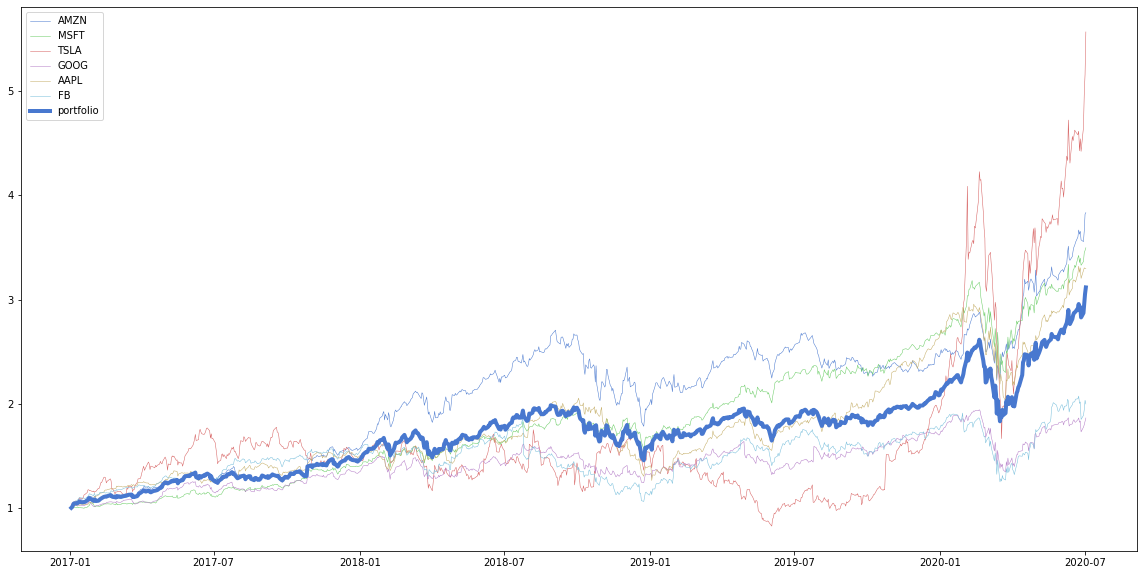

In [442]:
# Suppose we have a portfolio which is the sum of all stocks
# Once again portfolio = portfolio/portfolio[0] (capture releative movement)
portfolio = closing.sum(axis=1)
portfolio = portfolio/portfolio[0]
returns['portfolio'] = portfolio
plotStocks(returns)

In [318]:
def computeVolatility(returns):
    # calculating volatility of stocks and the portfolio
    perDailyChange = returns.pct_change() #percentage daily change
    logReturns = np.log(perDailyChange+1)
    volatility = logReturns.std()*np.sqrt(252)
    return volatility

computeVolatility(returns)
#So buying all stocks results in a portfolio lowers the  volatitlity making for a safer investment.

Symbols
AMZN         0.295889
MSFT         0.286787
TSLA         0.584055
GOOG         0.277373
AAPL         0.303516
FB           0.338354
portfolio    0.267862
dtype: float64

In [6]:
import seaborn as sns


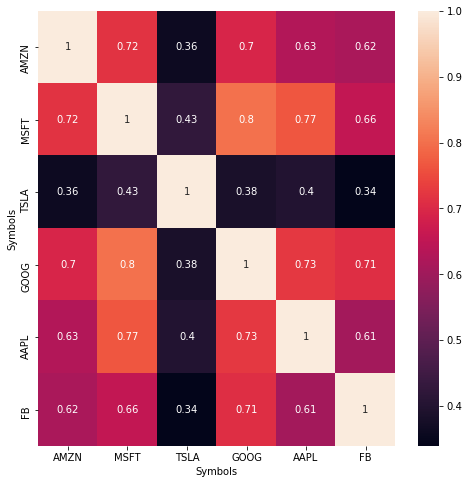

In [8]:
logReturns = np.log(returns.pct_change()+1)
logReturnsCorr = logReturns.iloc[1:,0:-1].corr()
plt.figure(figsize=(8,8))
sns.heatmap(logReturnsCorr,annot=True);

#Tesla has the weakest correlation to the other 5 companies, dur to its high variance

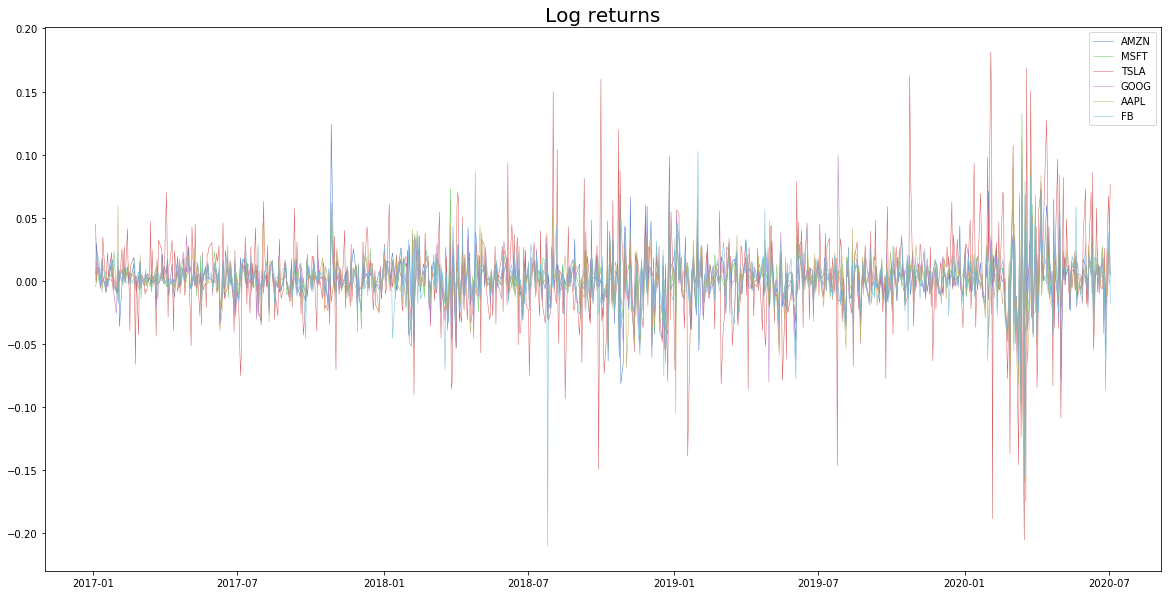

In [393]:
#We can use the bootstrap method to take random samples of all stocks in our portfolio and aggregate
def bootstrap(stockLogReturns,nsims,periods,weights): 
    prfAvgReturn = logReturns.iloc[:,0:-1].dropna()
    prfAvgReturn = (prfAvgReturn*weights).mean(axis=1)
    bootstrap = np.empty(shape = (periods,nsims))
    for i in range(nsims):
        samp = np.random.choice(prfAvgReturn,periods)
        bootstrap[:,i] = samp

    bootstrap = 1+(pd.DataFrame(bootstrap).shift(1).fillna(0))
    return bootstrap.cumprod(axis=0)
    
#portfolio
stockLogReturns = logReturns.iloc[1:,0:-1]
plotStocks(stockLogReturns)
plt.title('Log returns',fontsize=20);

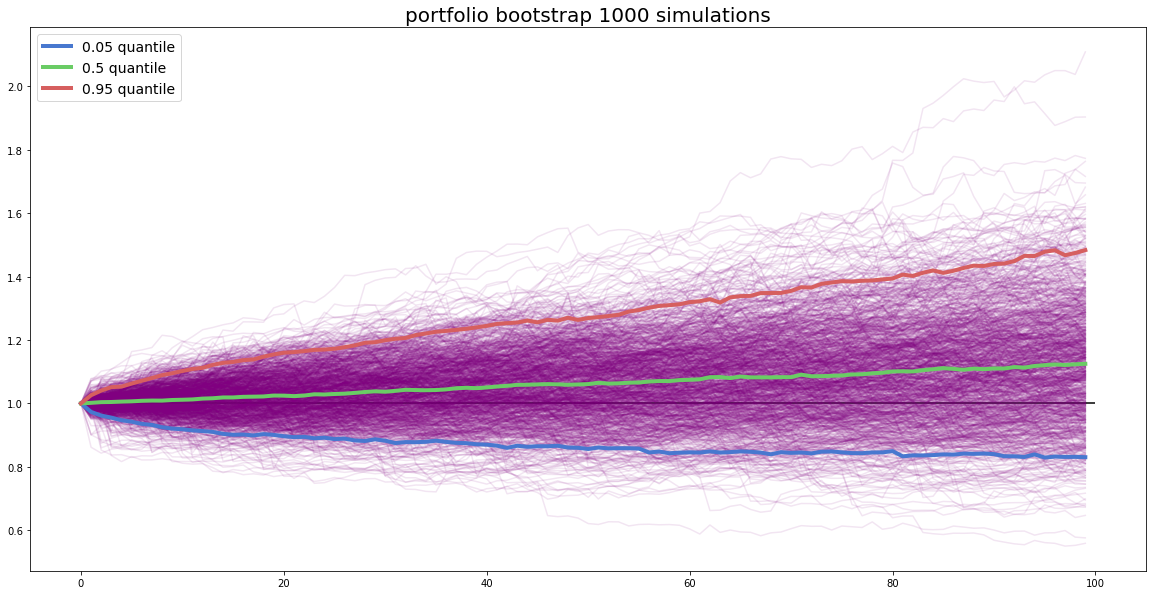

In [404]:
bs = bootstrap(stockLogReturns,1000,100,np.array([1,1,1,1,1,1]))
qs = [0.05,0.5,0.95]
quantiles = bs.quantile(qs,axis=1)

plt.figure(figsize=(20,10))
plt.plot(bs,color='purple',alpha=0.1);
for q in range(3):
    plt.plot(quantiles.iloc[q,:],label=str(qs[q])+' quantile',linewidth=4)
plt.legend(fontsize = 14)
plt.title('portfolio bootstrap 1000 simulations',fontsize=20);
plt.hlines(1,0,100)

In [339]:

#Instead of simply buying all stocks, suppose we only choose to buy certain quantities of each
# let theese be weight which sum to 1

num_stocks = returns.shape[1]-1
nfolios = 10000
performance = np.empty(shape=(nfolios,3))
weights = np.empty(shape = (nfolios,num_stocks))
for f in range(nfolios):
    w = np.random.uniform(size=num_stocks)
    w = w/w.sum()
    portfolio = (returns.iloc[:,0:-1]*w).sum(axis=1)
    portfolioLogReturn = np.log(portfolio.pct_change()+1)
    volatility = portfolioLogReturn.std()*np.sqrt(252)
    annualizedReturn = (portfolioLogReturn.mean()+1)**252 - 1
    sharpe = annualizedReturn/volatility
    entry = np.array([annualizedReturn,volatility,sharpe])
    #store metrics
    performance[f,:] = entry
    #store weights
    weights[f,:] = w



In [336]:
performance[0:10,:]

array([[0.35014026, 0.26202543, 1.33628348],
       [0.4724085 , 0.33990991, 1.38980503],
       [0.37212618, 0.27122076, 1.37204165],
       [0.42143488, 0.27883394, 1.51141888],
       [0.42322179, 0.28372163, 1.49167967],
       [0.34500655, 0.26272747, 1.3131727 ],
       [0.41357113, 0.28042453, 1.47480367],
       [0.42821612, 0.28253026, 1.51564692],
       [0.35993872, 0.27884284, 1.29083007],
       [0.44319136, 0.31040258, 1.42779533]])

In [347]:
portfolios = pd.DataFrame(performance,columns=['Return','Risk','Sharpe'])
maxsharpe = np.where(portfolios.Sharpe == portfolios.Sharpe.max())

# maximum sharpe ratio portfolio
best = portfolios.iloc[maxsharpe[0][0],:]
optimalWeights = weights[maxsharpe[0][0],:]

print('best portfolio: \n',best,'\n')
print('optimal weights \n',optimalWeights)

best portfolio: 
 Return    0.476281
Risk      0.278929
Sharpe    1.707532
Name: 2128, dtype: float64 

optimal weights 
 [3.65848669e-01 1.99238077e-01 1.76594425e-01 2.38255987e-02
 2.34402446e-01 9.07852786e-05]


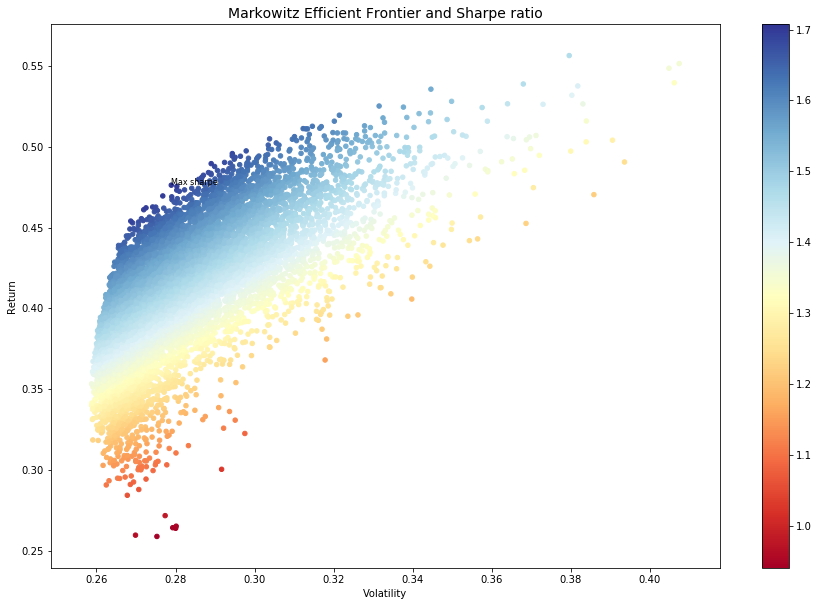

In [460]:
plt.figure(figsize=(15,10))
plt.scatter(x=portfolios.Risk,y=portfolios.Return,
            c=portfolios.Sharpe,s=20,alpha=1,
            cmap='RdYlBu')
plt.colorbar()
plt.title('Markowitz Efficient Frontier and Sharpe ratio',fontsize=14)
plt.annotate('Max sharpe',(best.Risk,best.Return),fontsize=8)
plt.xlabel('Volatility')
plt.ylabel('Return');

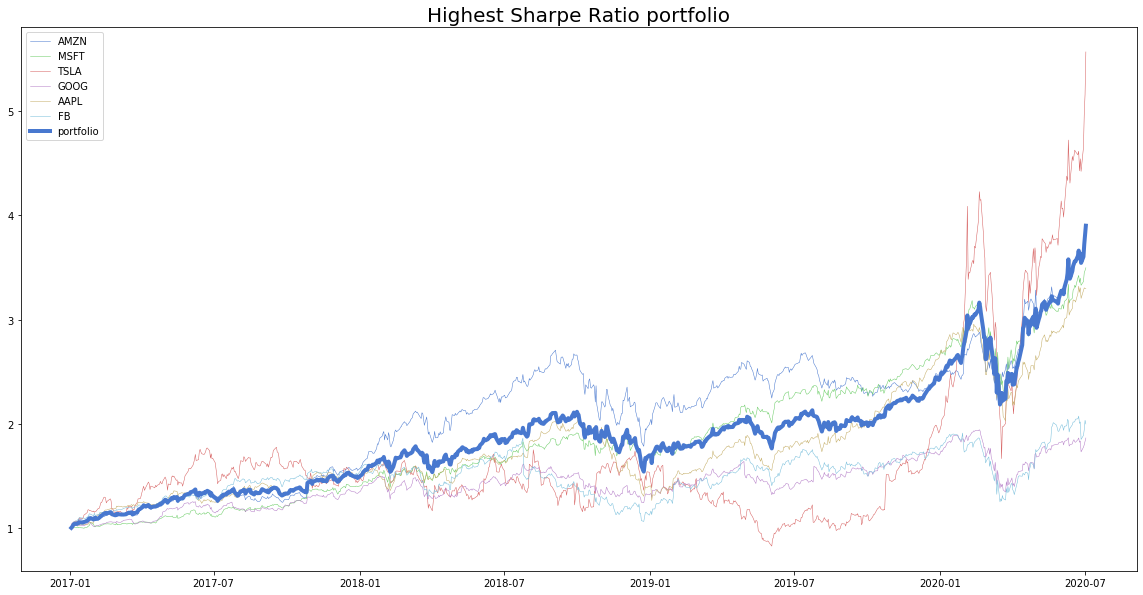

In [408]:
bestPortfolio = (returns.iloc[:,0:-1]*optimalWeights).sum(axis=1)
returns['portfolio'] = bestPortfolio/bestPortfolio[0]
plotStocks(returns)
plt.title('Highest Sharpe Ratio portfolio',fontsize=20);

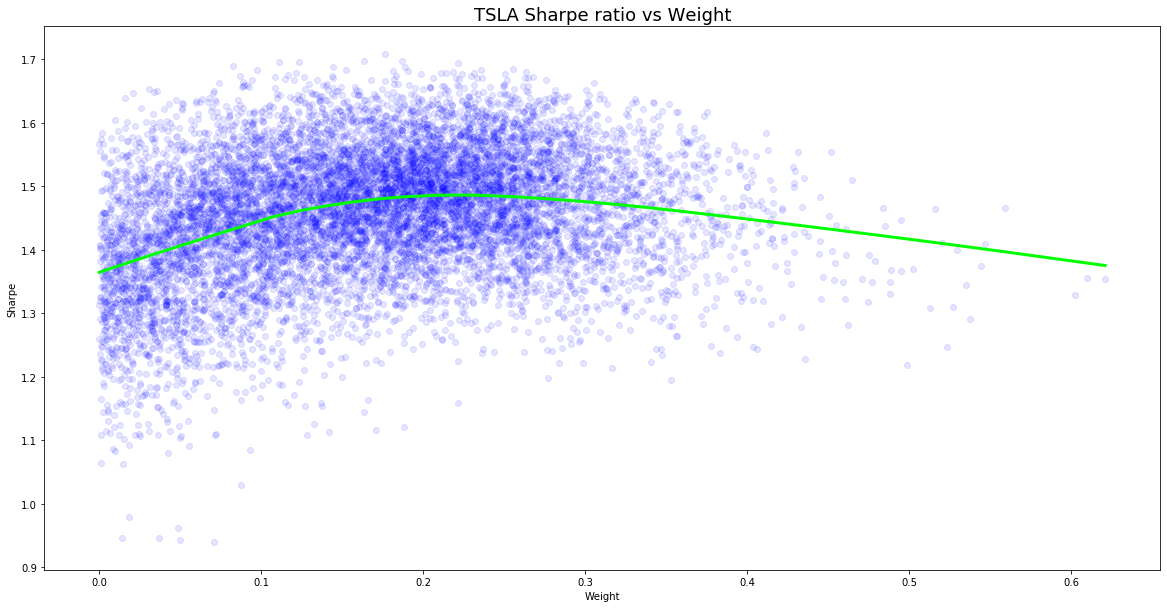

In [434]:

lowess = sm.nonparametric.lowess(exog=stockWeights.TSLA,endog=portfolios.Sharpe)
weights.shape
returns.iloc[:,0:-1].columns.values
stockWeights = pd.DataFrame(weights,columns = 
                           returns.iloc[:,0:-1].columns.values)

plt.figure(figsize=(20,10))
plt.scatter(x=stockWeights.TSLA,y=portfolios.Sharpe,alpha=0.1,color='blue')
plt.plot(lowess[:,0],lowess[:,1],color='lime',linewidth=3)
plt.xlabel('Weight');
plt.ylabel('Sharpe');
plt.title('TSLA Sharpe ratio vs Weight',fontsize=18);

#We can also plot shrpe ratio againr=t weight of TSLA stock.

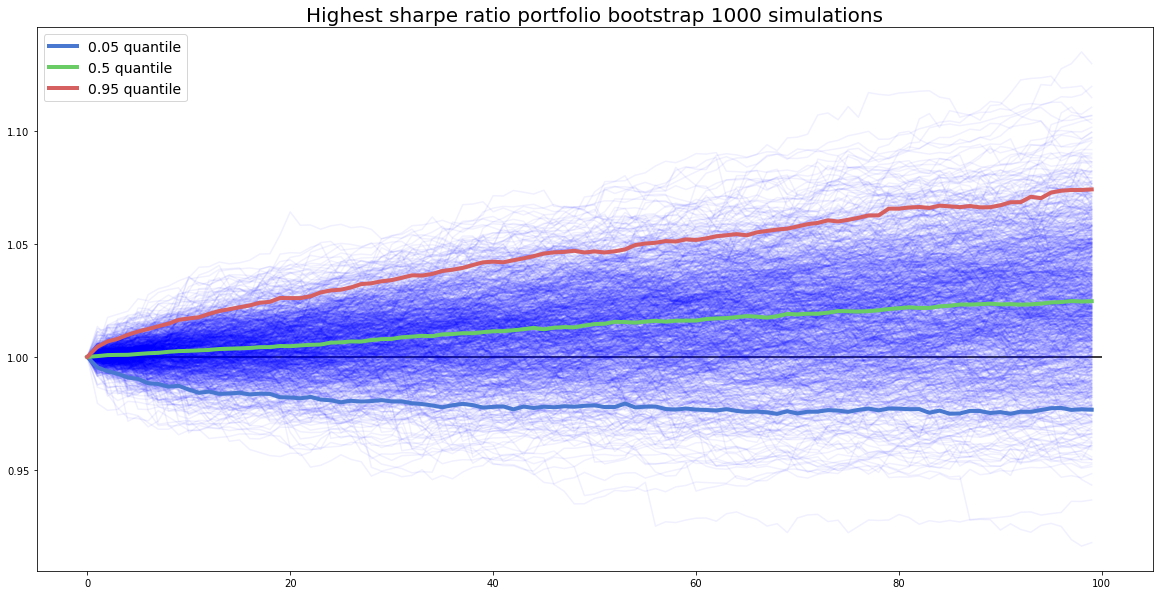

In [437]:
bs = bootstrap(stockLogReturns,1000,100,weights=optimalWeights)
qs = [0.05,0.5,0.95]
quantiles = bs.quantile(qs,axis=1)

plt.figure(figsize=(20,10))
plt.plot(bs,color = 'blue',alpha=0.06);
for q in range(3):
    plt.plot(quantiles.iloc[q,:],label=str(qs[q])+' quantile',linewidth=4);
plt.legend(fontsize = 14)
plt.title('Highest sharpe ratio portfolio bootstrap 1000 simulations',fontsize=20);
plt.hlines(1,0,100);